<a href="https://colab.research.google.com/github/5ohyun/Stock_SSPharm/blob/main/%EC%82%BC%EC%84%B1%EC%A0%9C%EC%95%BD_%EC%98%88%EC%B8%A1_%EC%BD%94%EB%93%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## (1) 데이터 수집

- 주식, 공매도, 배당, 금 가격, 코스피, 환율 데이터를 날짜 기준으로 병합

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
!pip install optuna

In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import statsmodels.api as sm
from datetime import datetime
import optuna
from lightgbm import LGBMClassifier
from xgboost import XGBRegressor
from optuna import Trial
from optuna.samplers import TPESampler
from sklearn.metrics import mean_squared_error

from sklearn import preprocessing
from tqdm import tqdm
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Activation, Flatten, Dropout
from keras.layers import SimpleRNN, LSTM, GRU


plt.rc('font', family='NanumBarunGothic') 

In [ ]:
os.chdir("/content/drive/MyDrive/팀프로젝트/삼성제약")

1. 제약 데이터

In [ ]:
stock5=pd.read_csv("삼성제약 15년도.csv",encoding='UTF-8')
stock6=pd.read_csv("삼성제약 16년도.csv",encoding='UTF-8')
stock7=pd.read_csv("삼성제약 17년도.csv",encoding='UTF-8')
stock8=pd.read_csv("삼성제약 18년도.csv",encoding='UTF-8')
stock9=pd.read_csv("삼성제약 19년도.csv",encoding='UTF-8')

stock = pd.DataFrame()

for i in [stock5, stock6, stock7, stock8, stock9] : 
  i=i.sort_values(by='년/월/일',ascending=True)
  i = i.reset_index(drop=True)
  stock=pd.concat([stock,i])

stock = stock.reset_index(drop=True)
stock['년/월/일']=stock['년/월/일'].astype(str).str.replace('/',"-")


for i in ['종가', '거래량(주)', '거래대금(원)', '시가', '고가', '저가', '시가총액(백만)','상장주식수(주)'] :
  stock[i]=stock[i].str.replace(",", "").astype(float)


stock=stock[['년/월/일', '종가', '거래량(주)', '거래대금(원)', '시가', '고가', '저가', '시가총액(백만)','상장주식수(주)']]

stock=stock.rename(columns={'년/월/일':'date','종가':'c_price'})

2. 공매도

In [ ]:
pubsale=pd.read_csv("삼성제약 공매도.csv",encoding='UTF-8')
pubsale=pubsale.rename(columns={'일자':'date','공매도거래량':'pubsale'})

pubsale['pubsale']=pubsale['pubsale'].str.replace(",", "").astype(float)
pubsale['공매도거래대금']=pubsale['공매도거래대금'].str.replace(",", "").astype(float)

pubsale = pubsale.reset_index(drop=True)

pubsale=pubsale[['date','pubsale','공매도거래대금']]

3. 배당

In [ ]:
div5=pd.read_csv("삼성제약 배당 15년도.csv",encoding='UTF-8')
div6=pd.read_csv("삼성제약 배당 16년도.csv",encoding='UTF-8')
div7=pd.read_csv("삼성제약 배당 17년도.csv",encoding='UTF-8')
div8=pd.read_csv("삼성제약 배당 18년도.csv",encoding='UTF-8')
div9=pd.read_csv("삼성제약 배당 19년도.csv",encoding='UTF-8')

div = pd.DataFrame()

for i in [div5,div6,div7,div8,div9] : 
  i = i.sort_values(by='일자',ascending=True)
  i = i.reset_index(drop=True)
  div=pd.concat([div,i])

div = div.reset_index(drop=True)
div=div.rename(columns={'일자':'date','종가':'배당종가'})

div['date']=div['date'].astype(str).str.replace('/',"-")


for i in ['배당종가','BPS','PBR'] : 
  div[i]=div[i].astype(str).str.replace(",", "").astype(float)

div=div[['date','배당종가','BPS','PBR']]

4.금 가격

In [ ]:
gold=pd.read_csv("일자별 금시세.csv",encoding='UTF-8')
gold=gold.sort_values(by='년/월/일',ascending=True)
gold = gold.reset_index(drop=True)
gold=gold.rename(columns={'년/월/일':'date','원/g 종가':'gold','원/g 시가':'gold_start'})

gold['gold_start']=gold['gold_start'].str.replace(",", "").astype(float)
gold['gold']=gold['gold'].str.replace(",", "").astype(float)

5.코스피

In [ ]:
kospi=pd.read_csv("코스피지수 의약품.csv",encoding='UTF-8',header=None)
kospi=kospi.rename(columns={0:'date',1:'kospi'})
kospi=kospi.drop(0)
kospi=kospi.drop(1)
kospi = kospi.reset_index(drop=True)
#kospi['년/월/일']=kospi['년/월/일'].astype(str).str.replace('-',"/")
kospi['kospi']=kospi['kospi'].str.replace(",", "").astype(float)

6. 환율 데이터

In [ ]:
exrate5=pd.read_csv("환율 15년도.csv",encoding='UTF-8')
exrate6=pd.read_csv("환율 16년도.csv",encoding='UTF-8')
exrate7=pd.read_csv("환율 17년도.csv",encoding='UTF-8')
exrate8=pd.read_csv("환율 18년도.csv",encoding='UTF-8')
exrate9=pd.read_csv("환율 19년도.csv",encoding='UTF-8')

exrate = pd.DataFrame()

for i in [exrate5,exrate6,exrate7,exrate8,exrate9] : 
  i = i.sort_values(by='거래일자',ascending=True)
  i = i.reset_index(drop=True)
  exrate=pd.concat([exrate,i])

exrate = exrate.reset_index(drop=True)
exrate=exrate.rename(columns={'거래일자':'date','환율종가':'exrate'})

exrate = exrate[['date','exrate']]

for i in ['exrate'] : 
  exrate[i]=exrate[i].astype(str).str.replace(",", "").astype(float)

In [ ]:
a1=pd.merge(stock,exrate,on='date',how='left')
a3=pd.merge(a1,pubsale,on='date',how='left')
a4=pd.merge(a3,div,on='date',how='left')
a5=pd.merge(a4,gold,on='date',how='left')
a6=pd.merge(a5,kospi,on='date',how='left')

a6['date']=pd.to_datetime(a6['date'])
a6.index=a6['date']

In [ ]:
a6['count_lag1'] = a6['c_price'].shift(1)
a6['count_lag2'] = a6['c_price'].shift(2)
a6['count_lag3'] = a6['c_price'].shift(3)
a6['count_lag4'] = a6['c_price'].shift(4)
a6['count_lag5'] = a6['c_price'].shift(5)
a6['count_lag6'] = a6['c_price'].shift(6)

## (2) 데이터 설정

- Train set :  2015/01/02 ~ 2019/11/22 (Validation set : 2019/11/18~ 2019/11/22 )
- Test set : 2019/11/25 ~ 2019/11/29


In [ ]:
def datasplit_ts(raw, Y_colname, X_colname, criteria):
    raw_train = raw.loc[raw.index < criteria,:]
    raw_test = raw.loc[raw.index >= criteria,:]
    Y_train = raw_train[Y_colname]
    X_train = raw_train[X_colname]
    Y_test = raw_test[Y_colname]
    X_test = raw_test[X_colname]
    print('Train_size:', raw_train.shape, 'Test_size:', raw_test.shape)
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)
    return X_train, X_test, Y_train, Y_test


Y_colname = ['c_price']
X_remove = ['date','배당종가']
X_colname = [x for x in a6.columns if x not in Y_colname+X_remove]
X_train, X_test, Y_train, Y_test  = datasplit_ts(a6,Y_colname,X_colname,'2019-11-25')

Train_size: (1202, 24) Test_size: (5, 24)
X_train: (1202, 21) Y_train: (1202, 1)
X_test: (5, 21) Y_test: (5, 1)


## (3) 데이터 정제 


- 삼성제약 종가 기준으로 병합한 Train 데이터 프레임 NA 처리 ( 환율, 금 가격 )

In [ ]:
X_train=X_train.reset_index()

print(X_train.index[X_train['exrate'].isnull()])
print(X_train.index[X_train['gold'].isnull()])
print(X_train.index[X_train['gold_start'].isnull()])

Int64Index([198, 220, 280, 285, 305, 321, 322, 403, 431, 644], dtype='int64')
Int64Index([797, 1054], dtype='int64')
Int64Index([797, 1054], dtype='int64')


In [ ]:
for i in [198, 220, 280, 285, 305, 321, 322, 403, 431, 644]:    
    X_train['exrate'].iloc[i]=np.mean([X_train['exrate'].iloc[i-1],X_train['exrate'].iloc[i+1]])

for i in [797, 1054]:    
    X_train['gold'][i]=np.mean([X_train['gold'][i-1],X_train['gold'][i+1]])
    X_train['gold_start'][i]=np.mean([X_train['gold_start'][i-1],X_train['gold_start'][i+1]])

X_train['exrate'].fillna(method='ffill',inplace=True)

In [ ]:
X_train.describe()

,거래량(주),거래대금(원),시가,고가,저가,시가총액(백만),상장주식수(주),exrate,pubsale,공매도거래대금,BPS,PBR,gold,gold_start,kospi,count_lag1,count_lag2,count_lag3,count_lag4,count_lag5,count_lag6
count,1.202000e+03,1.202000e+03,1202.000000,1202.000000,1202.000000,1202.000000,1.202000e+03,1202.000000,1202.000000,1.202000e+03,1202.000000,1202.000000,1202.000000,1202.000000,1202.000000,1201.000000,1200.00000,1199.000000,1198.000000,1197.000000,1196.000000
mean,1.004998e+06,6.114887e+09,5462.404326,5627.753744,5302.936772,192912.010815,4.097565e+07,1136.145385,19502.051581,8.888705e+07,1745.303661,3.969493,46218.968386,46242.163062,9784.442995,5456.802664,5457.75000,5458.586322,5459.298831,5459.849624,5460.351171
std,3.323770e+06,1.733475e+10,3585.009578,3759.817184,3412.859026,73554.201931,1.261779e+07,50.781276,56231.799124,2.054638e+08,436.751564,4.004512,3779.308193,3767.642134,2388.065861,3580.179479,3581.52156,3582.898816,3584.310138,3585.757562,3587.215561
min,2.509900e+04,9.253956e+07,1645.000000,1890.000000,1645.000000,53052.000000,2.267187e+07,1.127800,0.000000,0.000000e+00,1019.000000,0.800000,39900.000000,40000.000000,4445.840000,1815.000000,1815.00000,1815.000000,1815.000000,1815.000000,1815.000000
25%,1.576302e+05,5.266486e+08,3091.250000,3187.500000,3025.000000,151558.000000,2.868383e+07,1114.320000,1382.750000,5.530188e+06,1543.000000,1.490000,43915.000000,43912.500000,8056.662500,3090.000000,3088.75000,3087.500000,3086.250000,3085.000000,3083.750000
50%,2.816750e+05,1.350732e+09,3972.500000,4030.000000,3892.500000,171761.000000,3.971357e+07,1132.320000,6137.000000,2.777182e+07,2074.000000,2.150000,45575.000000,45570.000000,9566.910000,3970.000000,3967.50000,3965.000000,3960.000000,3955.000000,3955.000000
75%,6.803558e+05,4.016717e+09,6790.000000,6900.000000,6657.500000,210081.000000,5.813574e+07,1167.845000,16765.250000,8.788213e+07,2076.000000,4.430000,47350.000000,47300.000000,11444.102500,6780.000000,6785.00000,6790.000000,6795.000000,6800.000000,6800.000000
max,5.752795e+07,2.576227e+11,20850.000000,21900.000000,19350.000000,529525.000000,5.861113e+07,1239.280000,827486.000000,2.535291e+09,2261.000000,20.510000,60510.000000,60480.000000,15950.420000,20900.000000,20900.00000,20900.000000,20900.000000,20900.000000,20900.000000


No handles with labels found to put in legend.


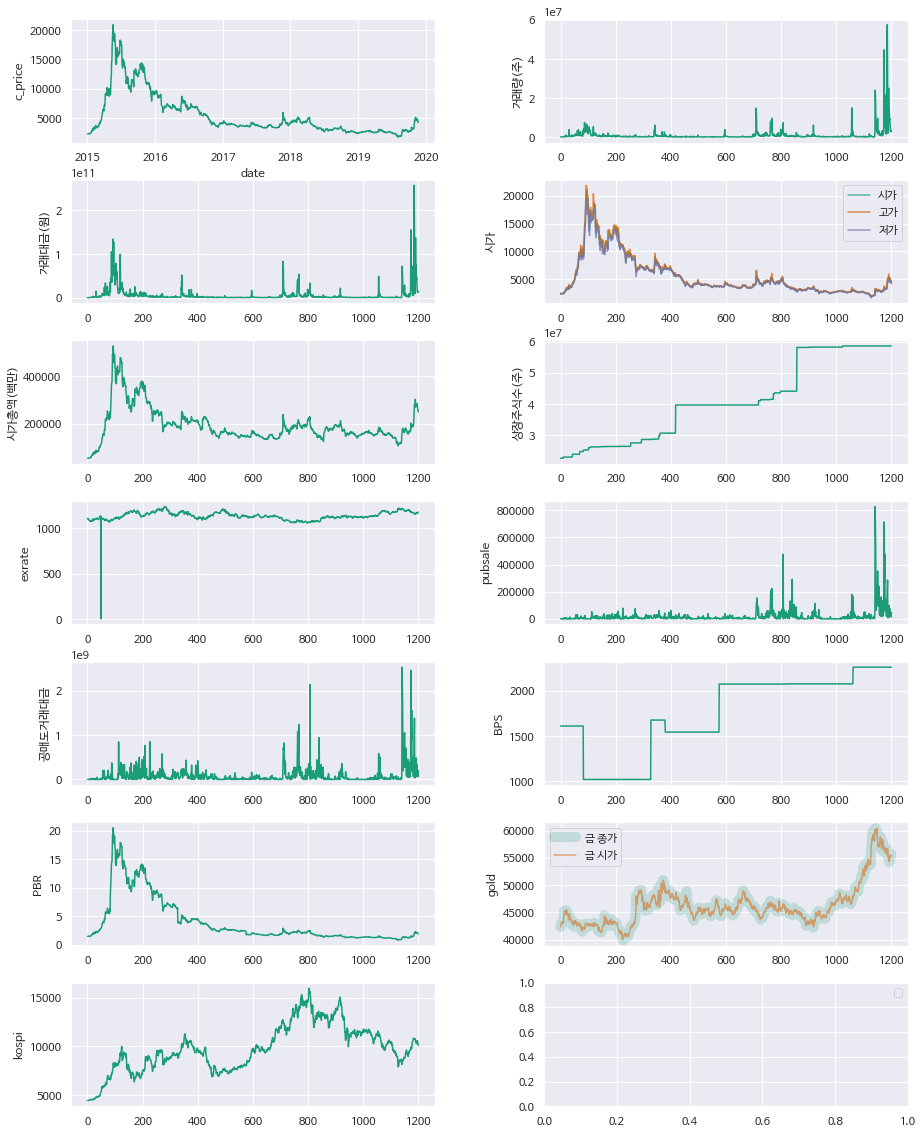

In [ ]:
sns.set_palette("Dark2")

f, ax = plt.subplots(7, 2, figsize=(15, 20))

sns.lineplot(data=Y_train['c_price'], ax=ax[0][0])
sns.lineplot(data=X_train['거래량(주)'], ax=ax[0][1])
sns.lineplot(data=X_train['거래대금(원)'], ax=ax[1][0])
sns.lineplot(data=X_train['시가'], ax=ax[1][1],label="시가",alpha = 0.7)
sns.lineplot(data=X_train['고가'], ax=ax[1][1],label="고가",alpha = 0.7)
sns.lineplot(data=X_train['저가'], ax=ax[1][1],label="저가",alpha = 0.7)
sns.lineplot(data=X_train['시가총액(백만)'], ax=ax[2][0])
sns.lineplot(data=X_train['상장주식수(주)'], ax=ax[2][1])
sns.lineplot(data=X_train['exrate'], ax=ax[3][0])
sns.lineplot(data=X_train['pubsale'], ax=ax[3][1])
sns.lineplot(data=X_train['공매도거래대금'], ax=ax[4][0])
sns.lineplot(data=X_train['BPS'], ax=ax[4][1])
sns.lineplot(data=X_train['PBR'], ax=ax[5][0])
sns.lineplot(data=X_train['gold'], ax=ax[5][1],label="금 종가",alpha = 0.2,linewidth=10)
sns.lineplot(data=X_train['gold_start'], ax=ax[5][1],label="금 시가",alpha = 0.5)
sns.lineplot(data=X_train['kospi'], ax=ax[6][0])

plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.legend()
plt.show()

- exrate (환율 값) outlier 존재 : 잘못 기입된 숫자

In [ ]:
X_train.iloc[49]['exrate']

date          2015-03-17 00:00:00
거래량(주)                     376404
거래대금(원)               1.72252e+09
시가                           4650
고가                           4660
저가                           4490
시가총액(백만)                   110274
상장주식수(주)              2.39727e+07
exrate                     1.1278
pubsale                      1176
공매도거래대금               5.41136e+06
BPS                          1610
PBR                          2.86
gold                        42700
gold_start                  43100
kospi                     5333.94
count_lag1                   4530
count_lag2                   4520
count_lag3                   4470
count_lag4                   4100
count_lag5                   4100
count_lag6                   4210
Name: 49, dtype: object

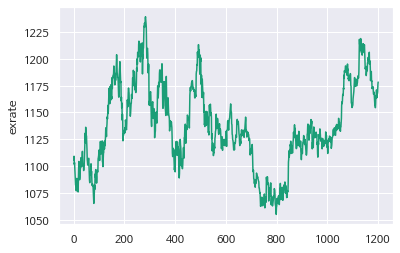

In [ ]:
X_train['exrate'][49] = 1127.8

sns.lineplot(data=X_train['exrate'])

## (4) 파생변수 생성

- 시간 관련 변수 생성

In [ ]:
X_train['date']=pd.to_datetime(X_train['date'])
X_train.index=X_train['date']

X_test=X_test.reset_index()
X_test['date']=pd.to_datetime(X_test['date'])
X_test.index=X_test['date']

for time_data in [X_train,X_test] :
  time_data['Year'] = time_data['date'].dt.year
  time_data['Quarter'] = time_data['date'].dt.quarter
  time_data['Quater_ver2'] = time_data['Quarter'] + (time_data.Year - time_data.Year.min()) * 4
  time_data['DayofWeek'] = time_data['date'].dt.dayofweek
  time_data['Month'] = time_data['date'].dt.month

  print(time_data.head(5))

                 date    거래량(주)      거래대금(원)  ...  Quater_ver2  DayofWeek  Month
date                                          ...                               
2015-01-02 2015-01-02  131029.0  306413400.0  ...            1          4      1
2015-01-05 2015-01-05   83185.0  193754150.0  ...            1          0      1
2015-01-06 2015-01-06   72097.0  168748770.0  ...            1          1      1
2015-01-07 2015-01-07   81393.0  195321070.0  ...            1          2      1
2015-01-08 2015-01-08   60837.0  145256675.0  ...            1          3      1

[5 rows x 27 columns]
                 date     거래량(주)       거래대금(원)  ...  Quater_ver2  DayofWeek  Month
date                                            ...                               
2019-11-25 2019-11-25  1908892.0  8.178295e+09  ...            4          0     11
2019-11-26 2019-11-26  7224166.0  3.198747e+10  ...            4          1     11
2019-11-27 2019-11-27  2675268.0  1.156499e+10  ...            4          2   

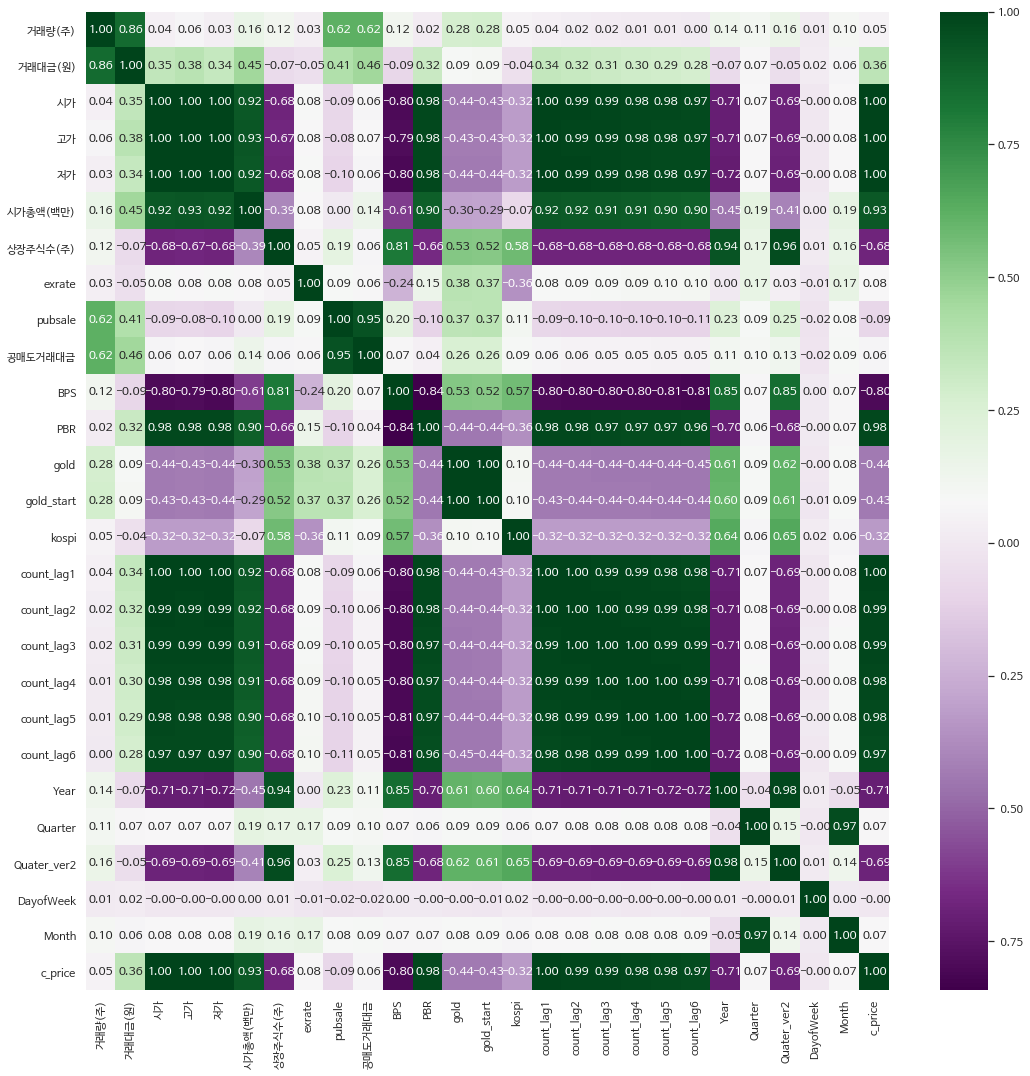

In [ ]:
f, ax = plt.subplots(figsize=(18,18))
Train= pd.concat([X_train, Y_train], axis=1)
corr = Train.corr()
sns.heatmap(corr,annot=True,fmt='.2f', ax=ax,cmap="PRGn")

## (5) 모델링

- Train / Validation 데이터 설정

In [ ]:
X_train=X_train.dropna()

X_train_make = X_train.loc[X_train.index < '2019-11-18',:]
Y_train_make = Y_train.loc[Y_train.index < '2019-11-18',:]

X_val = X_train.loc[X_train.index >= '2019-11-18',:]
Y_val = Y_train.loc[Y_train.index >= '2019-11-18',:]

print('X_train:', X_train_make.shape, 'Y_train:', Y_train_make.shape)
print('X_test:', X_val.shape, 'Y_test:', Y_val.shape)

X_train: (1191, 27) Y_train: (1197, 1)
X_test: (5, 27) Y_test: (5, 1)


In [ ]:
X_remove = ['시가', '고가', '저가','gold_start'] # 다중공선성 우려 - 변수 제거
colname=[x for x in X_train.columns if x not in X_remove]

X_train = X_train[colname]
X_test=X_test[colname]

X_train_make = X_train_make[colname]
X_val=X_val[colname]

In [ ]:
X_train = X_train.reset_index(drop=True)
X_train = X_train.drop('date',axis=1)
X_test = X_test.reset_index(drop=True)
X_test = X_test.drop('date',axis=1)


X_train_make = X_train_make.reset_index(drop=True)
X_train_make = X_train_make.drop('date',axis=1)
X_val = X_val.reset_index(drop=True)
X_val = X_val.drop('date',axis=1)

- 변수 스케일링

In [ ]:
scaler_X = preprocessing.MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_X_val = preprocessing.MinMaxScaler()

X_make_scaled = scaler_X_val.fit_transform(X_train_make)
X_val_scaled = scaler_X_val.transform(X_val)

- 지표 평가 함수 생성

In [ ]:
def evaluation(Y_real, Y_pred, graph_on=False):
    loss_length = len(Y_real.values.flatten()) - len(Y_pred)
    if loss_length != 0:
        Y_real = Y_real[loss_length:]
    if graph_on == True:
        pd.concat([Y_real, pd.DataFrame(Y_pred, index=Y_real.index, columns=['prediction'])], axis=1).plot(kind='line', figsize=(20,6),
                                                                                                           xlim=(Y_real.index.min(),Y_real.index.max()),
                                                                                                           linewidth=3, fontsize=20)
        plt.title('Time Series of Target', fontsize=20)
        plt.xlabel('Index', fontsize=15)
        plt.ylabel('Target Value', fontsize=15)
    MAE = abs(Y_real.values.flatten() - Y_pred).mean()
    MSE = ((Y_real.values.flatten() - Y_pred)**2).mean()
    MAPE = (abs(Y_real.values.flatten() - Y_pred)/Y_real.values.flatten()*100).mean()
    Score = pd.DataFrame([MAE, MSE, MAPE], index=['MAE', 'MSE', 'MAPE'], columns=['Score']).T
    Residual = pd.DataFrame(Y_real.values.flatten() - Y_pred, index=Y_real.index, columns=['Error'])
    return Score, Residual


def evaluation_trte(Y_real_tr, Y_pred_tr, Y_real_te, Y_pred_te, graph_on=False):
    Score_tr, Residual_tr = evaluation(Y_real_tr, Y_pred_tr, graph_on=graph_on)
    Score_te, Residual_te = evaluation(Y_real_te, Y_pred_te, graph_on=graph_on)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ['Train', 'Test']
    return Score_trte, Residual_tr, Residual_te

# XGB Regressor

- hyperparameter 튜닝 (Optuna)

In [ ]:
def objectiveXGB(trial: Trial) :
    params = {
        "random_state": 42,
        "learning_rate": trial.suggest_loguniform('learning_rate' ,1e-3, 1e-1),
        "n_estimators": trial.suggest_int('n_estimators',100,1000),
        "max_depth": trial.suggest_int("max_depth", 1, 20),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "subsample": trial.suggest_float("subsample", 0.3, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 300),
    }
    
    model = XGBRegressor(**params)
    model.fit(
        X_make_scaled,
        Y_train_make[6:],
        eval_set=[(X_make_scaled, Y_train_make[6:]), (X_val_scaled, Y_val)],
        early_stopping_rounds=100,
        verbose=False,
    )

    xgb_pred = model.predict(X_val_scaled)
    score = mean_squared_error(Y_val, xgb_pred)
    
    return score


sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="xgb_parameter_opt",
    direction="minimize",
    sampler=sampler)

study.optimize(objectiveXGB, n_trials=30)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2021-07-28 13:37:12,320] A new study created in memory with name: xgb_parameter_opt


[13:37:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-28 13:37:14,194] Trial 0 finished with value: 4084.0144087314607 and parameters: {'learning_rate': 0.005611516415334507, 'n_estimators': 956, 'max_depth': 15, 'colsample_bytree': 0.759195090518222, 'subsample': 0.40921304830970556, 'min_child_weight': 47}. Best is trial 0 with value: 4084.0144087314607.


[13:37:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-28 13:37:16,083] Trial 1 finished with value: 603152.202126503 and parameters: {'learning_rate': 0.0013066739238053278, 'n_estimators': 880, 'max_depth': 13, 'colsample_bytree': 0.8248435466776274, 'subsample': 0.3144091460070617, 'min_child_weight': 291}. Best is trial 0 with value: 4084.0144087314607.


[13:37:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-28 13:37:16,418] Trial 2 finished with value: 38472.321001291275 and parameters: {'learning_rate': 0.04622589001020832, 'n_estimators': 291, 'max_depth': 4, 'colsample_bytree': 0.5100427059120604, 'subsample': 0.5129695700716763, 'min_child_weight': 158}. Best is trial 0 with value: 4084.0144087314607.


[13:37:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-28 13:37:17,308] Trial 3 finished with value: 20645.660078012945 and parameters: {'learning_rate': 0.007309539835912915, 'n_estimators': 362, 'max_depth': 13, 'colsample_bytree': 0.4836963163912251, 'subsample': 0.5045012539746527, 'min_child_weight': 110}. Best is trial 0 with value: 4084.0144087314607.


[13:37:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-28 13:37:18,848] Trial 4 finished with value: 5752.057873773575 and parameters: {'learning_rate': 0.008168455894760165, 'n_estimators': 807, 'max_depth': 4, 'colsample_bytree': 0.708540663048167, 'subsample': 0.7146901982034297, 'min_child_weight': 14}. Best is trial 0 with value: 4084.0144087314607.


[13:37:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-28 13:37:19,341] Trial 5 finished with value: 29526.199256896973 and parameters: {'learning_rate': 0.016409286730647923, 'n_estimators': 253, 'max_depth': 2, 'colsample_bytree': 0.9693313223519999, 'subsample': 0.9759424231521916, 'min_child_weight': 243}. Best is trial 0 with value: 4084.0144087314607.


[13:37:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-28 13:37:19,817] Trial 6 finished with value: 3636042.311973727 and parameters: {'learning_rate': 0.0040665633135147945, 'n_estimators': 188, 'max_depth': 14, 'colsample_bytree': 0.6640914962437607, 'subsample': 0.38542676439134516, 'min_child_weight': 149}. Best is trial 0 with value: 4084.0144087314607.


[13:37:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-28 13:37:22,331] Trial 7 finished with value: 488312.2712219238 and parameters: {'learning_rate': 0.001171593739230706, 'n_estimators': 919, 'max_depth': 6, 'colsample_bytree': 0.7975133706123891, 'subsample': 0.5181977532625877, 'min_child_weight': 157}. Best is trial 0 with value: 4084.0144087314607.


[13:37:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-28 13:37:22,959] Trial 8 finished with value: 38501.381585121155 and parameters: {'learning_rate': 0.0123999678368461, 'n_estimators': 266, 'max_depth': 20, 'colsample_bytree': 0.8650796940166687, 'subsample': 0.9576492590949324, 'min_child_weight': 269}. Best is trial 0 with value: 4084.0144087314607.


[13:37:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-28 13:37:23,422] Trial 9 finished with value: 38611.73959732056 and parameters: {'learning_rate': 0.015696396388661146, 'n_estimators': 930, 'max_depth': 2, 'colsample_bytree': 0.5175897174514872, 'subsample': 0.33165910223737666, 'min_child_weight': 98}. Best is trial 0 with value: 4084.0144087314607.


[13:37:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-28 13:37:25,414] Trial 10 finished with value: 353924.3052053094 and parameters: {'learning_rate': 0.0030769008283689906, 'n_estimators': 603, 'max_depth': 20, 'colsample_bytree': 0.6276520012698079, 'subsample': 0.7488857775363251, 'min_child_weight': 7}. Best is trial 0 with value: 4084.0144087314607.


[13:37:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-28 13:37:28,003] Trial 11 finished with value: 10635.133878946304 and parameters: {'learning_rate': 0.004153930961246181, 'n_estimators': 697, 'max_depth': 8, 'colsample_bytree': 0.7319387651769488, 'subsample': 0.7608561127220177, 'min_child_weight': 14}. Best is trial 0 with value: 4084.0144087314607.


[13:37:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-28 13:37:29,003] Trial 12 finished with value: 2217.32614402771 and parameters: {'learning_rate': 0.03755208747064172, 'n_estimators': 766, 'max_depth': 17, 'colsample_bytree': 0.9329490243015314, 'subsample': 0.6946472193225903, 'min_child_weight': 57}. Best is trial 12 with value: 2217.32614402771.


[13:37:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-28 13:37:30,158] Trial 13 finished with value: 2177.139390707016 and parameters: {'learning_rate': 0.09831789687261878, 'n_estimators': 738, 'max_depth': 17, 'colsample_bytree': 0.9913272298120274, 'subsample': 0.8683707923068775, 'min_child_weight': 57}. Best is trial 13 with value: 2177.139390707016.


[13:37:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-28 13:37:31,513] Trial 14 finished with value: 1841.0774344921113 and parameters: {'learning_rate': 0.06900808149700377, 'n_estimators': 467, 'max_depth': 17, 'colsample_bytree': 0.9971309251404658, 'subsample': 0.8395072565015608, 'min_child_weight': 56}. Best is trial 14 with value: 1841.0774344921113.


[13:37:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-28 13:37:32,159] Trial 15 finished with value: 25445.553103458882 and parameters: {'learning_rate': 0.09584836614920764, 'n_estimators': 478, 'max_depth': 18, 'colsample_bytree': 0.989633026224043, 'subsample': 0.8569660950708582, 'min_child_weight': 80}. Best is trial 14 with value: 1841.0774344921113.


[13:37:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-28 13:37:32,528] Trial 16 finished with value: 35464.753304719925 and parameters: {'learning_rate': 0.09774340251803003, 'n_estimators': 459, 'max_depth': 11, 'colsample_bytree': 0.9110934757966447, 'subsample': 0.8575513341456639, 'min_child_weight': 213}. Best is trial 14 with value: 1841.0774344921113.


[13:37:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-28 13:37:33,432] Trial 17 finished with value: 5668.332529735565 and parameters: {'learning_rate': 0.045744766556166466, 'n_estimators': 624, 'max_depth': 17, 'colsample_bytree': 0.9975823228750262, 'subsample': 0.8714049661959368, 'min_child_weight': 45}. Best is trial 14 with value: 1841.0774344921113.


[13:37:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-28 13:37:33,861] Trial 18 finished with value: 2958.854369831085 and parameters: {'learning_rate': 0.06723367741306548, 'n_estimators': 507, 'max_depth': 10, 'colsample_bytree': 0.8828036809296594, 'subsample': 0.6172628133130101, 'min_child_weight': 128}. Best is trial 14 with value: 1841.0774344921113.


[13:37:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-28 13:37:34,318] Trial 19 finished with value: 9185.428272485733 and parameters: {'learning_rate': 0.029874994525908312, 'n_estimators': 690, 'max_depth': 20, 'colsample_bytree': 0.5715436535083985, 'subsample': 0.9220387404241495, 'min_child_weight': 192}. Best is trial 14 with value: 1841.0774344921113.


[13:37:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-28 13:37:35,082] Trial 20 finished with value: 3388.0668434143067 and parameters: {'learning_rate': 0.06787508638503117, 'n_estimators': 395, 'max_depth': 16, 'colsample_bytree': 0.9396613173211978, 'subsample': 0.8067181307004928, 'min_child_weight': 64}. Best is trial 14 with value: 1841.0774344921113.


[13:37:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-28 13:37:36,050] Trial 21 finished with value: 4817.531664991378 and parameters: {'learning_rate': 0.02935419146899245, 'n_estimators': 784, 'max_depth': 18, 'colsample_bytree': 0.9988525285113945, 'subsample': 0.6643641284019963, 'min_child_weight': 42}. Best is trial 14 with value: 1841.0774344921113.


[13:37:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-28 13:37:36,610] Trial 22 finished with value: 10891.02076973915 and parameters: {'learning_rate': 0.027294603714758506, 'n_estimators': 772, 'max_depth': 18, 'colsample_bytree': 0.40393980470958374, 'subsample': 0.6659447946187734, 'min_child_weight': 76}. Best is trial 14 with value: 1841.0774344921113.


[13:37:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-28 13:37:37,510] Trial 23 finished with value: 5123.791097545623 and parameters: {'learning_rate': 0.06330566479050162, 'n_estimators': 622, 'max_depth': 16, 'colsample_bytree': 0.9363024551697035, 'subsample': 0.8040989070788066, 'min_child_weight': 31}. Best is trial 14 with value: 1841.0774344921113.


[13:37:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-28 13:37:38,144] Trial 24 finished with value: 9661.75605301857 and parameters: {'learning_rate': 0.041984873087588394, 'n_estimators': 686, 'max_depth': 11, 'colsample_bytree': 0.8554135971884789, 'subsample': 0.9058253647364893, 'min_child_weight': 108}. Best is trial 14 with value: 1841.0774344921113.


[13:37:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-28 13:37:38,703] Trial 25 finished with value: 29935.602498626708 and parameters: {'learning_rate': 0.09455241195037464, 'n_estimators': 560, 'max_depth': 19, 'colsample_bytree': 0.9426556346346041, 'subsample': 0.6090028168716807, 'min_child_weight': 67}. Best is trial 14 with value: 1841.0774344921113.


[13:37:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-28 13:37:39,770] Trial 26 finished with value: 2926.5286565303804 and parameters: {'learning_rate': 0.09624514220627194, 'n_estimators': 839, 'max_depth': 15, 'colsample_bytree': 0.9982912007201672, 'subsample': 0.800870916613106, 'min_child_weight': 5}. Best is trial 14 with value: 1841.0774344921113.


[13:37:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-28 13:37:40,529] Trial 27 finished with value: 11396.715459871291 and parameters: {'learning_rate': 0.0545908745540979, 'n_estimators': 724, 'max_depth': 13, 'colsample_bytree': 0.9002267468504097, 'subsample': 0.9952694548042744, 'min_child_weight': 86}. Best is trial 14 with value: 1841.0774344921113.


[13:37:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-28 13:37:41,148] Trial 28 finished with value: 20778.467803919317 and parameters: {'learning_rate': 0.022650695627809754, 'n_estimators': 412, 'max_depth': 17, 'colsample_bytree': 0.7949070207400177, 'subsample': 0.7211515511701846, 'min_child_weight': 122}. Best is trial 14 with value: 1841.0774344921113.


[13:37:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-07-28 13:37:41,939] Trial 29 finished with value: 5750.172100305557 and parameters: {'learning_rate': 0.036573321697068846, 'n_estimators': 979, 'max_depth': 15, 'colsample_bytree': 0.767294452771828, 'subsample': 0.5860794258266406, 'min_child_weight': 32}. Best is trial 14 with value: 1841.0774344921113.


Best Score: 1841.0774344921113
Best trial: {'learning_rate': 0.06900808149700377, 'n_estimators': 467, 'max_depth': 17, 'colsample_bytree': 0.9971309251404658, 'subsample': 0.8395072565015608, 'min_child_weight': 56}


In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
xgb_params=study.best_trial.params
xgb_params

{'colsample_bytree': 0.9971309251404658,
 'learning_rate': 0.06900808149700377,
 'max_depth': 17,
 'min_child_weight': 56,
 'n_estimators': 467,
 'subsample': 0.8395072565015608}

In [ ]:
xgb = XGBRegressor(**xgb_params)
xgb.fit(X_train_scaled, Y_train[6:])
Y_train_pred = xgb.predict(X_train_scaled)
Y_test_pred = xgb.predict(X_test_scaled)

[13:37:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
Score_xgb, Residual_tr, Residual_te = evaluation_trte(Y_train[6:], Y_train_pred, Y_test, Y_test_pred, graph_on=False)

display(Score_xgb)

,MAE,MSE,MAPE
Train,67.031401,35921.220972,0.933747
Test,193.274902,51486.759189,4.625189


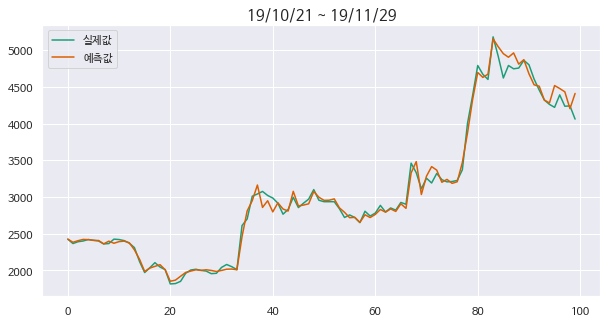

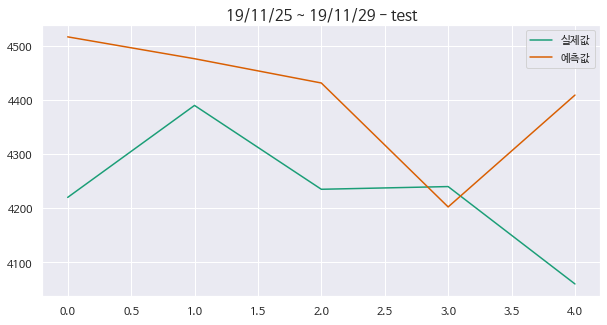

In [ ]:
pr=np.append(Y_train_pred,Y_test_pred)
sc=pd.concat([Y_train[6:],Y_test])

f, ax = plt.subplots(figsize=(10, 5))

sns.lineplot(data=sc.values[-100:].flatten(),ax=ax,label="실제값")
sns.lineplot(data=pr[-100:],ax=ax,label="예측값")
plt.title('19/10/21 ~ 19/11/29', fontsize=15)



f, ax = plt.subplots(figsize=(10, 5))

plt.title('19/11/25 ~ 19/11/29 - test', fontsize=15)
sns.lineplot(data=Y_test.values.flatten(),ax=ax,label="실제값")
sns.lineplot(data=Y_test_pred,ax=ax,label="예측값")

plt.legend()
plt.show()


# MLP

In [ ]:
scaler_Y_tr = preprocessing.MinMaxScaler()

Y_train_scaled = scaler_Y_tr.fit_transform(Y_train[6:])
Y_test_scaled = scaler_Y_tr.transform(Y_test)

In [ ]:
# from keras.callbacks import EarlyStopping

batch_size = 32
epoch =  300
verbose = 1
dropout_ratio = 0

# MLP
model = Sequential()
model.add(Dense(128, input_shape=(X_train_scaled.shape[1],), activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(128, activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(64, activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# early_stopping = EarlyStopping()
model_fit = model.fit(X_train_scaled, Y_train_scaled, 
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose),#callbacks=[early_stopping] )
# prediction
Y_train_pred = model.predict(X_train_scaled)
Y_test_pred = model.predict(X_test_scaled)

# evaluation
# result = model.evaluate(X_test, Y_test_pred)
if scaler_Y_tr != []:
    Y_train_tr = scaler_Y_tr.inverse_transform(Y_train_scaled)
    Y_train_pred_tr = scaler_Y_tr.inverse_transform(Y_train_pred)
    Y_test_tr = scaler_Y_tr.inverse_transform(Y_test_scaled)
    Y_test_pred_tr = scaler_Y_tr.inverse_transform(Y_test_pred)
Score_MLP, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train_tr), Y_train_pred_tr.flatten(), 
                                                      pd.DataFrame(Y_test_tr), Y_test_pred_tr.flatten(), graph_on=False)
display(Score_MLP)



Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_65 (Dense)             (None, 128)               2944      
_________________________________________________________________
dropout_52 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_66 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_53 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_67 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_54 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_68 (Dense)             (None, 64)              

,MAE,MSE,MAPE
Train,62.034444,6682.866622,1.163638
Test,95.388281,13191.485344,2.291087


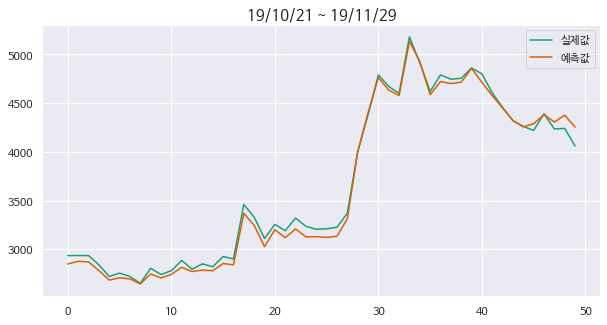

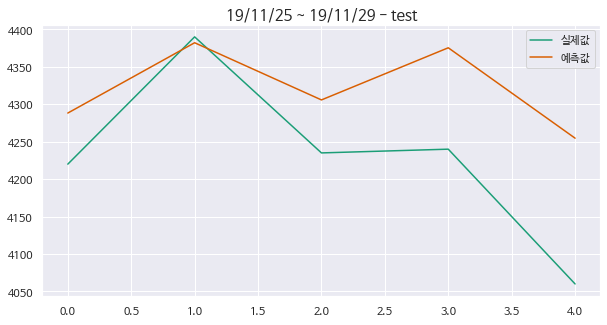

In [ ]:
pr=np.append(Y_train_pred_tr,Y_test_pred_tr)
sc=pd.concat([Y_train[6:],Y_test])
sc = sc.reset_index(drop=True).values.flatten()

f, ax = plt.subplots(figsize=(10, 5))

sns.lineplot(data=sc[-50:],ax=ax,label="실제값")
sns.lineplot(data=pr[-50:],ax=ax,label="예측값")
plt.title('19/10/21 ~ 19/11/29', fontsize=15)


f, ax = plt.subplots(figsize=(10, 5))

plt.title('19/11/25 ~ 19/11/29 - test', fontsize=15)
sns.lineplot(data=Y_test.values.flatten(),ax=ax,label="실제값")
sns.lineplot(data=Y_test_pred_tr.flatten(),ax=ax,label="예측값")

plt.legend()
plt.show()
